In [2]:
import response_utils
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use a LaTeX-compatible serif font
    "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
})

%load_ext autoreload
%autoreload 2

# Experiment 1: Uncoupled 3 box model

### $C(r)\frac{\partial T(t)}{\partial{t}} = F(t) + \lambda(r) T(t)$,
where $C(r)$ is the heat capacity ($C = \rho_{\text{w}} \, c_{\text{w}} \, h(r)$, $\rho_{\text{w}} = 10^3$, $c_{\text{w}} = 4 \times 10^3$), $T(t)$ is the temperature, $F(t)$ is the effective radiative forcing, and $\lambda(r)$ is the local feedback parameter; $r$ denotes the region.

This relationship represents warming due to effective radiative forcing (ERF). This problem in 1D assumes that we are averaging over a few locations (e.g. land, Southern Ocean, and Arctic). The parameters of interest are given by:

| Parameter                                        | Symbol       | Fast  | Intermediate | Slow  |
|--------------------------------------------------|--------------|-------|--------------|-------|
| Effective water depth (m)                        | $h(r)$       | 10    | 150          | 1500  |
| Local Feedback (W m<sup>-2</sup> K<sup>-1</sup>) | $\lambda(r)$ | -0.86 | -2.0         | -0.67 |

We consider the following forcing profiles of interest:

| Forcing Type | Functional Form           | Value(s)                              |
|--------------|---------------------------|---------------------------------------|
| Constant     | $F$                       | 3.7, 7.4                              |
| Exponential  | $a e^{t/t^*}$             | $a = F_{\text{final}} / e^{250/t^*}$  |
| Overshoot    | $a e^{\frac{-(t - b)^2}{2c^2}}$ | $a = 4$, $b = 200$, $c = 42.7$        |

where $F_{\text{final}}$ is the radiative forcing at the end of the simulation (e.g. 7 W m<sup>-2</sup> K<sup>-1</sup> for SSP370) and $t^*$ is 50 years.

In [5]:
# Grid parameters
dt = 1
Nt = 400 # Number of years
t = np.arange(0,dt*Nt,dt)
Nt = len(t)

# ODE parameters
rho_w = 1e3
c_w = 4e3
h = np.array([10.0, 150.0, 1500.0])
C = rho_w*c_w*h/3.154e7 # convert from seconds to years
lam = np.array([-0.86, -2.0, -0.67])
T0 = 0 # K
F0 = 1

# Forcing parameters
## 2xCO2 and 4xCO2 (constant forcing)
F_2xCO2 = response_utils.F_const(t, 3.7)
F_4xCO2 = response_utils.F_const(t, 7.4)

## RCP370
F_final = 0.4 # (W m^-2)
ts = 50
a_exp = F_final/np.exp(250*dt/ts)
F_exp = response_utils.F_exp(t, a_exp, ts)

## Overshoot
a_over = 2
b_over = 200
c_over = 70
F_over = response_utils.F_over(t, a_over, b_over, c_over)

## Impulse forcing
F0 = 1
F_pulse = response_utils.F_del(t, F0)
F_del = {'2xCO2':F_pulse,
         '4xCO2':F_pulse,
         'High Warming':F_pulse,
         'Overshoot':F_pulse}

## Compile all for diagnosis
F_all = {'2xCO2':F_2xCO2,
         '4xCO2':F_4xCO2,
         'High Warming':F_exp,
         'Overshoot':F_over}

# Plotting parameters
experiments = ['2xCO2','4xCO2','High Warming','Overshoot']
regions = ['Atmosphere', 'Shallow Ocean', 'Deep Ocean']
colors = ['g','r','b']

# Stochastic parameters
K = 0.5
N_ensemble = 50

# Generated perturbed ensemble
F_del_ensemble = response_utils.gen_F_ensemble(F_del, t, K, N_ensemble, experiments)
F_all_ensemble = response_utils.gen_F_ensemble(F_all, t, K, N_ensemble, experiments)

### Integrated solutions to experiments of interest

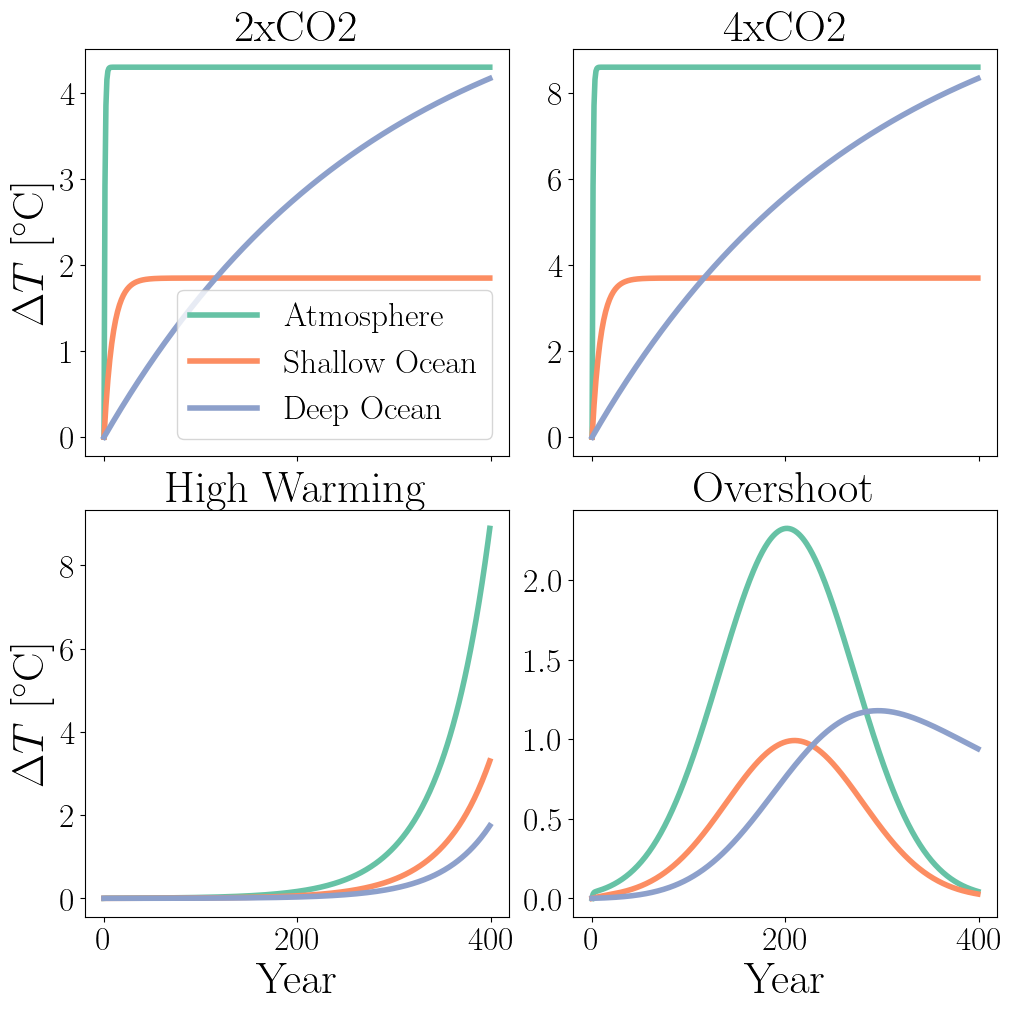

In [8]:
T_analytic, g_analytic, a_analytic = response_utils.timestep_uncoup(t, experiments, regions, F_all, lam, C, dt)
T_ensemble, g_ensemble, a_ensemble = response_utils.timestep_uncoup(t, experiments, regions, F_all_ensemble, lam, C, dt, N_ensemble)
#response_utils.plot_box_model(T_analytic, t, experiments, regions, colors, soln_type='Noiseless')
response_utils.plot_box_model2(T_analytic, t, experiments, regions, colors, soln_type='Noiseless')
#response_utils.plot_box_model(T_ensemble, t, experiments, regions, colors, soln_type='Noisy', ensemble=True)

#### Method 1: Direct derivation of Green's function

##### a) Without noise

Error from Raw estimation.
	L2 Error, 2xCO2: 0.0
	L2 Error, 4xCO2: 0.0
	L2 Error, RCP370: 0.0
	L2 Error, Overshoot: 0.0
Avg. L2 Error: 0.0

Error from Modal estimation.
	L2 Error, 2xCO2: 0.0
	L2 Error, 4xCO2: 0.0
	L2 Error, RCP370: 0.0
	L2 Error, Overshoot: 0.0
Avg. L2 Error: 0.0



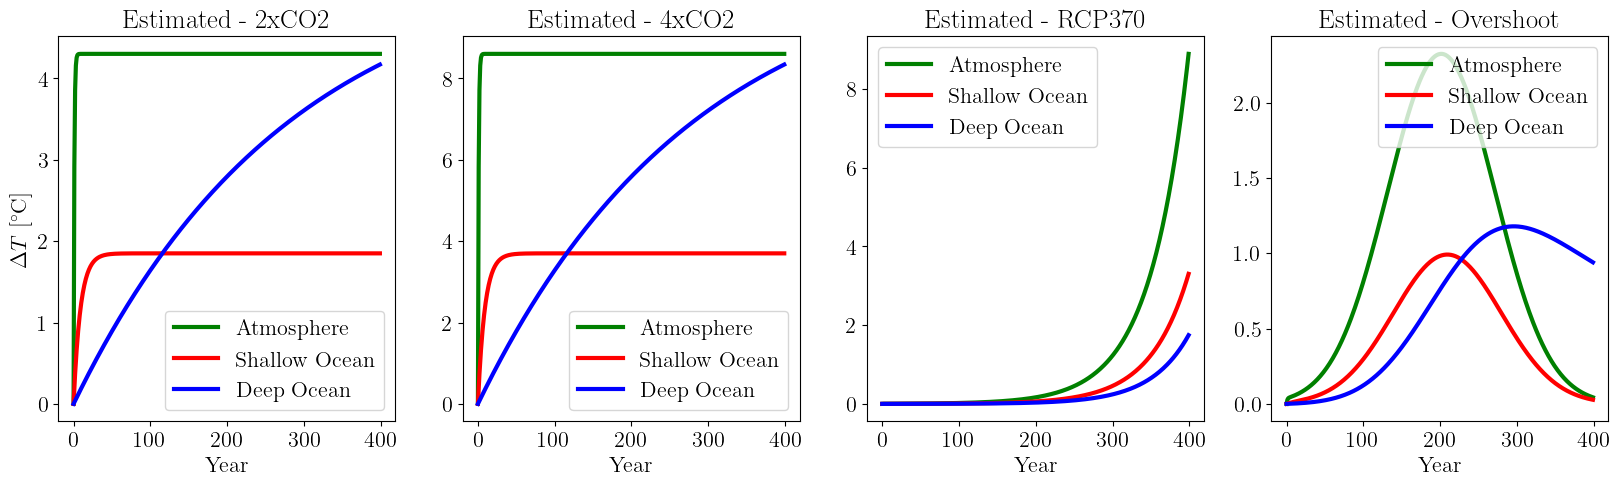

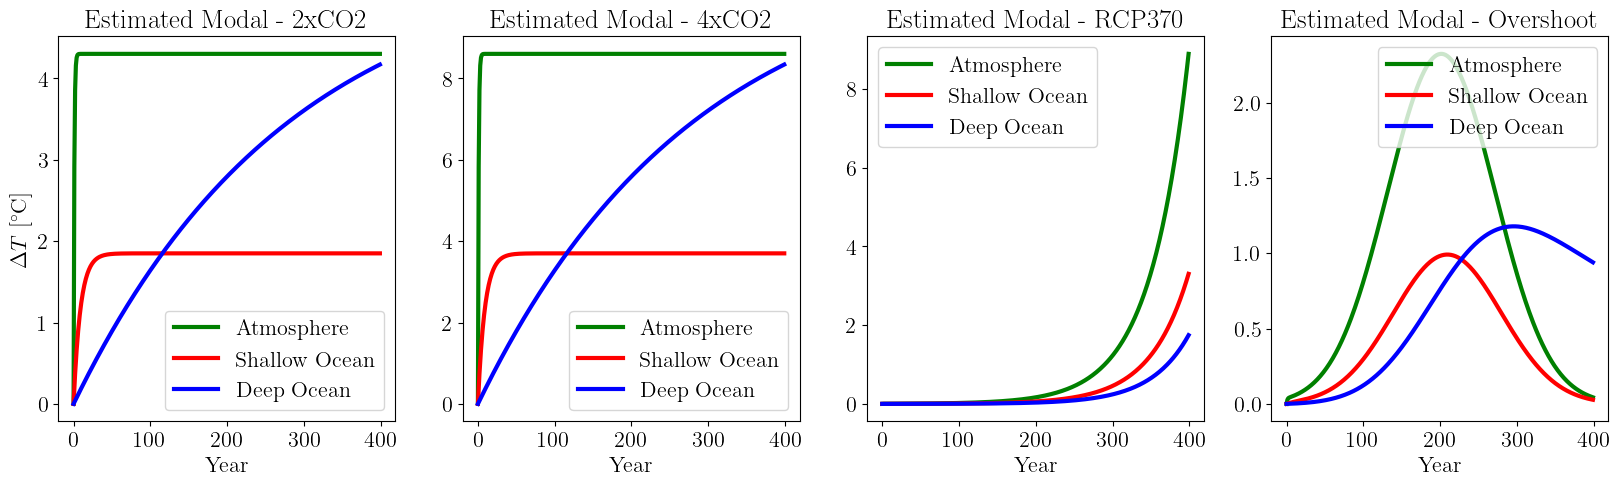

In [7]:
G_raw_direct, g_direct, a_direct = response_utils.timestep_uncoup(t, experiments, regions, F_del, lam, C, dt)

T_est_raw_1, T_est_modal_1 = response_utils.estimate_T_1D(T_analytic, F_all,
                                                      experiments, regions,
                                                      t, C, 'G', G_raw_direct, a_direct,
                                                      g_direct, T0, dt)

response_utils.plot_box_model(T_est_raw_1, t, experiments, regions, colors, soln_type='Estimated')
response_utils.plot_box_model(T_est_modal_1, t, experiments, regions, colors, soln_type='Estimated Modal')

L2_raw_1 = response_utils.calc_L2(T_analytic, T_est_raw_1, experiments, regions, 'Raw')
L2_modal_1 = response_utils.calc_L2(T_analytic, T_est_modal_1, experiments, regions, 'Modal')

##### b) With Noise

In [8]:
G_raw_direct_ensemble, g_direct_ensemble, a_direct_ensemble = response_utils.timestep_uncoup(t, experiments, regions, F_del_ensemble, lam, C, dt, N_ensemble)

L2_operator_raw_direct = response_utils.calc_L2_operator_ensemble(G_raw_direct, G_raw_direct_ensemble, experiments, regions, N_ensemble, 10)
L2_operator_modal_direct = response_utils.calc_L2_operator_ensemble(a_direct, a_direct_ensemble, experiments, regions, N_ensemble, 10)
response_utils.plot_L2_operator_ensemble(L2_operator_raw_direct, np.arange(1,N_ensemble+1), experiments, regions, colors, 'Raw')
response_utils.plot_L2_operator_ensemble(L2_operator_modal_direct, np.arange(1,N_ensemble+1), experiments, regions, colors, 'Modal')

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/chriswomack/anaconda3/envs/research/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/5v/9rw_h5d56d57jgsmbk2dfb980000gn/T/ipykernel_76267/2744712454.py", line 3, in <module>
    L2_operator_raw_direct = response_utils.calc_L2_operator_ensemble(G_raw_direct, G_raw_direct_ensemble, experiments, regions, N_ensemble, 10)
                             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/chriswomack/Documents/PhD/Project 1/response_utils.py", line 426, in calc_L2_operator_ensemble
    op_sample_mean[exp][j] = np.mean(op_ensemble[exp][j][sampled_indices, :], axis=0)
                                     ~~~~~~~~~~~~~~~~^^^
KeyError: 0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  Fi

#### Method 2: Direct inference of L from a dataset

##### a) Without noise

Error from Raw estimation.
	L2 Error, 2xCO2: 0.00015
	L2 Error, 4xCO2: 0.00015
	L2 Error, RCP370: 0.00297
	L2 Error, Overshoot: 1e-05
Avg. L2 Error: 0.00082



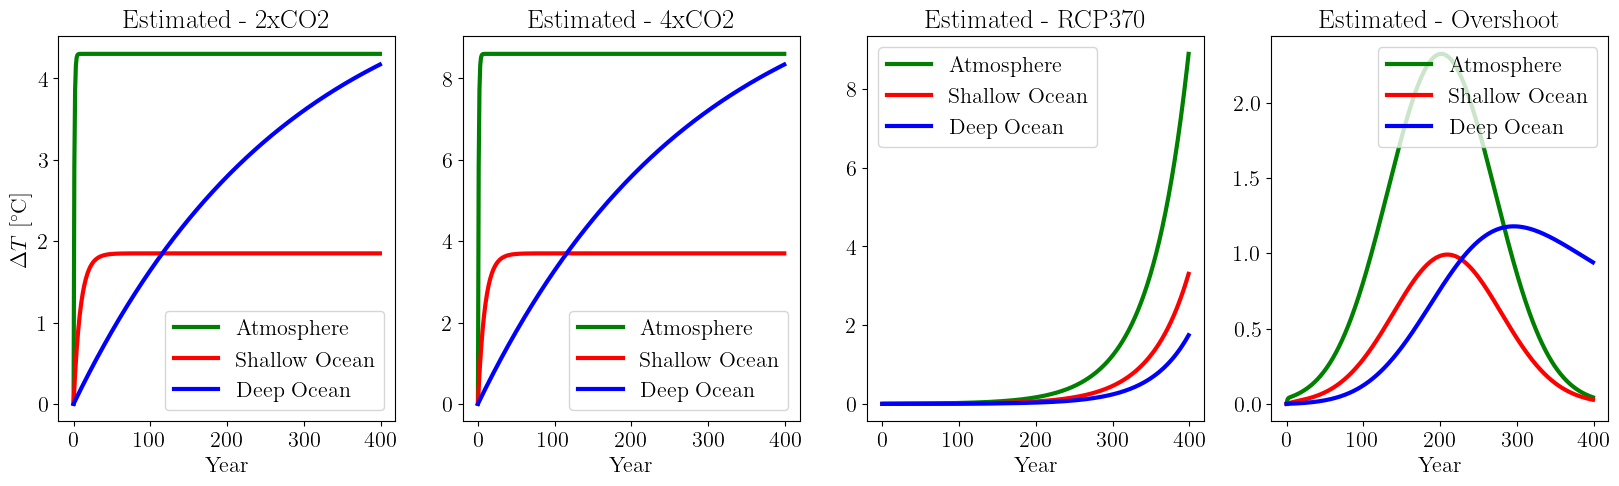

In [20]:
t_range = (0,400)
p = 1
L_raw, L_modal = {}, {}
for exp in experiments:
  L_raw[exp], L_modal[exp] = {}, {}
  for i in range(len(regions)):
    reg = regions[i]
    L_raw[exp][reg] = response_utils.calc_L_direct_1D(T_analytic[exp][reg], F_all[exp], t, t_range, C[i], p)
    #L_modal[exp][reg] = response_utils.calc_L_direct_1D(-a_analytic[exp][reg], F_all[exp], t, (0,400), C[i], p_order=1, modal=True, g=g_analytic[exp][reg])

T_est_raw_2, T_est_modal_2 = response_utils.estimate_T_1D(T_analytic, F_all,
                                                      experiments, regions,
                                                      t, C, 'L', L_raw, L_raw,
                                                      None, T0, dt)

response_utils.plot_box_model(T_est_raw_2, t, experiments, regions, colors, soln_type='Estimated')
#response_utils.plot_box_model(T_est_modal_2, t, experiments, regions, colors, soln_type='Estimated Modal')

L2_raw_2 = response_utils.calc_L2(T_analytic, T_est_raw_2, experiments, regions, 'Raw')
#L2_modal_2 = response_utils.calc_L2(T_analytic, T_est_modal_2, experiments, regions, 'Modal')

### Test sensitivity of L calculation
#### a) Derivative order

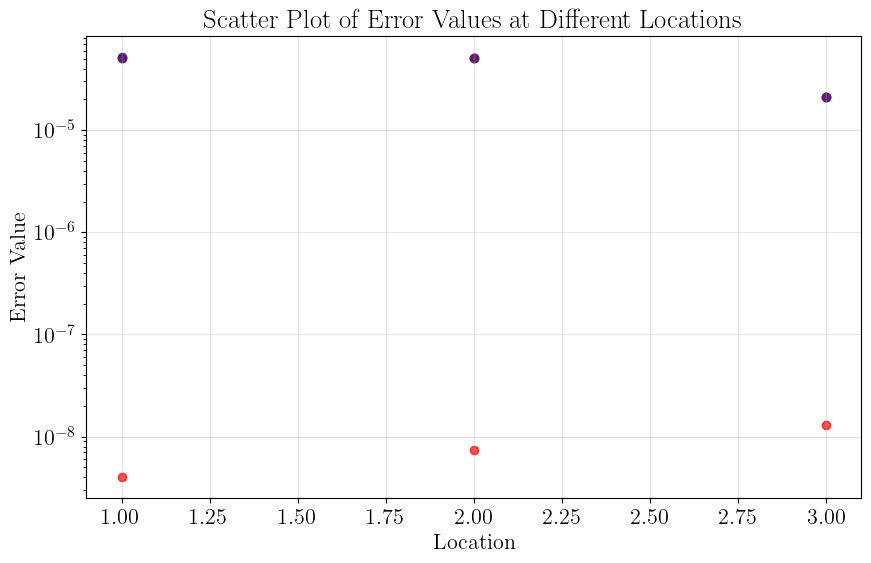

In [12]:
error = {}
exp='Overshoot'
t_range = (0,400)
for i, reg in enumerate(regions):
  L_true = lam[i]/C[i]
  error[reg] = []
  for p in [1,2,3,4]:
    L_raw = response_utils.calc_L_direct_1D(T_analytic[exp][reg], F_all[exp], t, t_range, C[i], p)
    error[reg].append(np.linalg.norm(L_true - L_raw))

response_utils.scatter_plot(error)

#### b) Time series for diagnosis

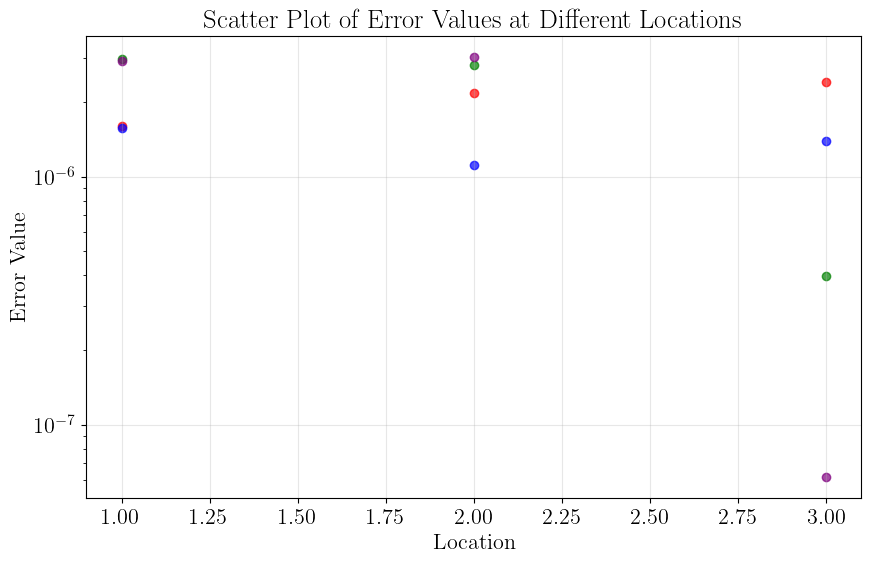

In [13]:
error = {}
exp='Overshoot'
#t_ranges = [(0,400),(0,100),(100,200),(300,400)]
t_ranges = [(200,250),(250,300),(300,350),(350,400)]
for i, reg in enumerate(regions):
  L_true = lam[i]/C[i]
  error[reg] = []
  for t_range in t_ranges:
    L_raw = response_utils.calc_L_direct_1D(T_analytic[exp][reg], F_all[exp], t, t_range, C[i], 1)
    error[reg].append(np.linalg.norm(L_true - L_raw))

response_utils.scatter_plot(error)

##### b) With noise

In [25]:
# Instantiate data structures
L_raw_ensemble, L_modal_ensemble = {}, {}
L2_operator_raw_L, L2_operator_modal_L = {}, {}
for exp in experiments:
  L_raw_ensemble[exp], L_modal_ensemble[exp] = {}, {}
  L2_operator_raw_L[exp], L2_operator_modal_L[exp] = {}, {}
  for reg in regions:
    L_raw_ensemble[exp][reg], L_modal_ensemble[exp][reg] = np.zeros((N_ensemble, 1)),  np.zeros((N_ensemble, 1))
    L2_operator_raw_L[exp][reg], L2_operator_modal_L[exp][reg] = [], []

# Iterate over ensemble members
N_samples = 10
N_trials = range(1, N_ensemble, 4)
for n in N_trials:

  # Instantiate temporary data structures
  L_raw_sample, L_modal_sample = {}, {}
  for exp in experiments:
    L_raw_sample[exp], L_modal_sample[exp] = {}, {}
    for reg in regions:
      L_raw_sample[exp][reg], L_modal_sample[exp][reg] = [], []

  # Repeat random sampling N_trials times
  for _ in range(N_samples):
    sampled_indices = np.random.choice(N_ensemble, size=n, replace=False)

    # Calculate linear operator
    for exp in experiments:
      F_sample_mean = np.mean(F_all_ensemble[exp][sampled_indices, :], axis=0)
      for i, reg in enumerate(regions):
        T_sample_mean = np.mean(T_ensemble[exp][reg][sampled_indices, :], axis=0)
        #a_sample_mean = np.mean(a_ensemble[exp][reg][sampled_indices, :], axis=0)
        #g_sample_mean = np.mean(g_ensemble[exp][reg][sampled_indices, :], axis=0)
        L_raw_sample[exp][reg].append(response_utils.calc_L_direct_1D(T_sample_mean, F_sample_mean, t, t_range, C[i], p))
        #L_modal_sample[exp][reg].append(response_utils.calc_L_direct_1D(-a_sample_mean, F_sample_mean, t, C[i], modal=True, g=g_sample_mean))

  # Save average linear operator
  for exp in experiments:
    for reg in regions:
      L_raw_ensemble[exp][reg] = np.mean(L_raw_sample[exp][reg])
      #L_modal_ensemble[exp][reg] = np.mean(L_modal_sample[exp][reg])

  # Calculate L2 operator error
  L2_operator_sample_raw = response_utils.calc_L2_operator(L_raw, L_raw_ensemble, experiments, regions)
  #L2_operator_sample_modal = response_utils.calc_L2_operator(L_modal, L_modal_ensemble, experiments, regions)
  for exp in experiments:
    for reg in regions:
      L2_operator_raw_L[exp][reg].append(L2_operator_sample_raw[exp][reg])
      #L2_operator_modal_L[exp][reg].append(L2_operator_sample_modal[exp][reg])

# Plot L2 operator error ensemble
response_utils.plot_L2_operator_ensemble(L2_operator_raw_L, N_trials, experiments, regions, colors, 'Raw')
#response_utils.plot_L2_operator_ensemble(L2_operator_modal_L, N_trials, experiments, regions, colors, 'Modal')

KeyError: 0

#### Method 3: Direct deconvolution of response function from dataset

##### a) Without noise

Error from Raw estimation.
	L2 Error, 2xCO2: 0.0
	L2 Error, 4xCO2: 0.0
	L2 Error, RCP370: 0.0
	L2 Error, Overshoot: 0.0
Avg. L2 Error: 0.0

Error from Modal estimation.
	L2 Error, 2xCO2: 0.0
	L2 Error, 4xCO2: 0.0
	L2 Error, RCP370: 0.0
	L2 Error, Overshoot: 0.0
Avg. L2 Error: 0.0



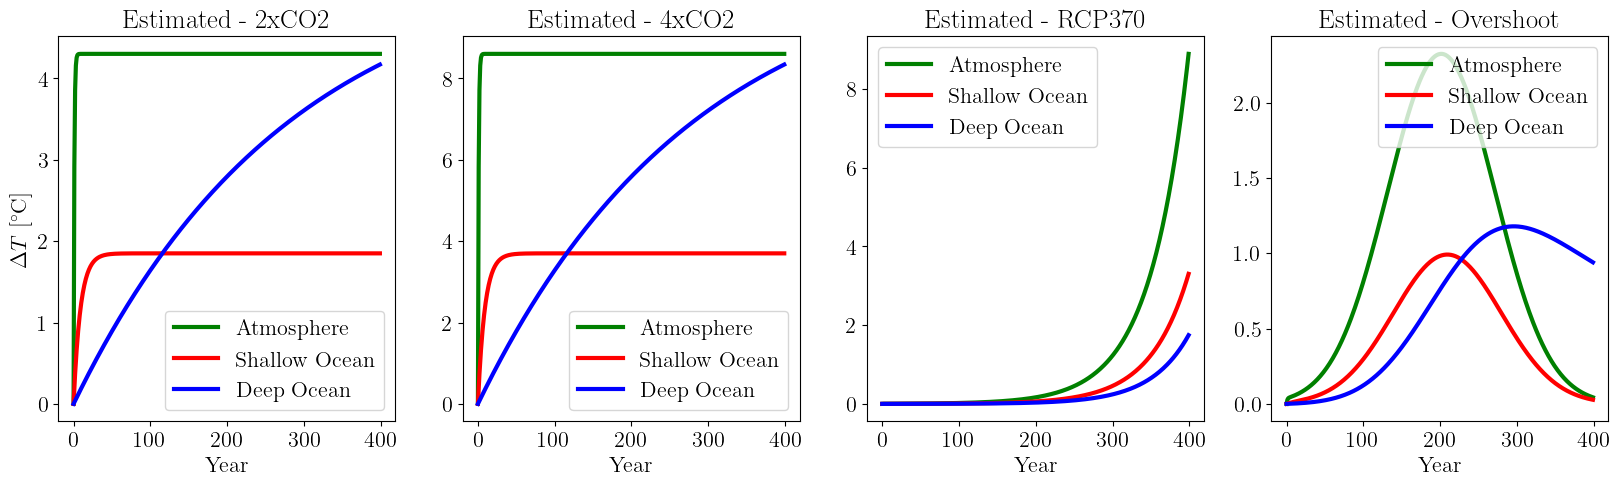

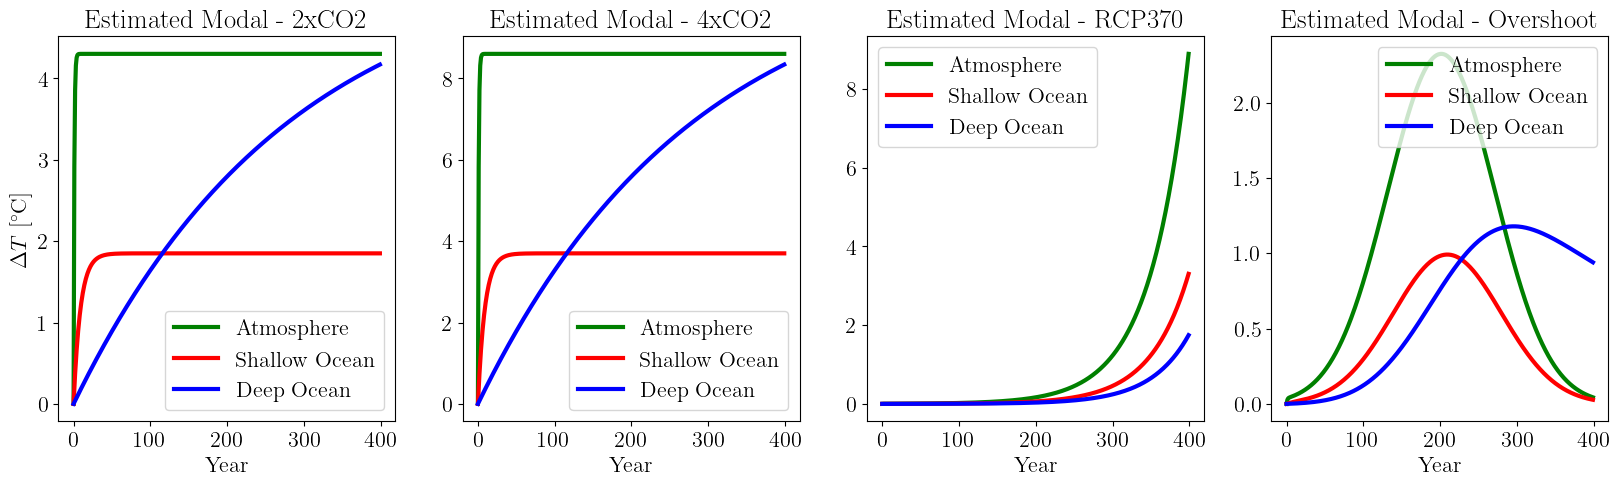

In [24]:
G_deconv, g_deconv, a_deconv = {}, {}, {}
for exp in experiments:
  G_deconv[exp], g_deconv[exp], a_deconv[exp] = {}, {}, {}
  for i in range(len(regions)):
    reg = regions[i]
    G_deconv[exp][reg] = response_utils.calc_G_deconv_1D(T_analytic[exp][reg], F_all[exp], dt=1)
    g_deconv[exp][reg], a_deconv[exp][reg] = response_utils.calc_modes_1D(G_deconv[exp][reg], t)

T_est_raw_3, T_est_modal_3 = response_utils.estimate_T_1D(T_analytic, F_all,
                                                      experiments, regions,
                                                      t, C, 'G', G_deconv, a_deconv,
                                                      g_deconv, T0, dt)

response_utils.plot_box_model(T_est_raw_3, t, experiments, regions, colors, soln_type='Estimated')
response_utils.plot_box_model(T_est_modal_3, t, experiments, regions, colors, soln_type='Estimated Modal')

L2_raw_3 = response_utils.calc_L2(T_analytic, T_est_raw_3, experiments, regions, 'Raw')
L2_modal_3 = response_utils.calc_L2(T_analytic, T_est_modal_3, experiments, regions, 'Modal')

##### b) With noise

/Users/chriswomack/anaconda3/envs/research/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:744: RuntimeWarning: overflow encountered in scalar divide
  x[i] /= A.data[A_diagonal_index_row_i]


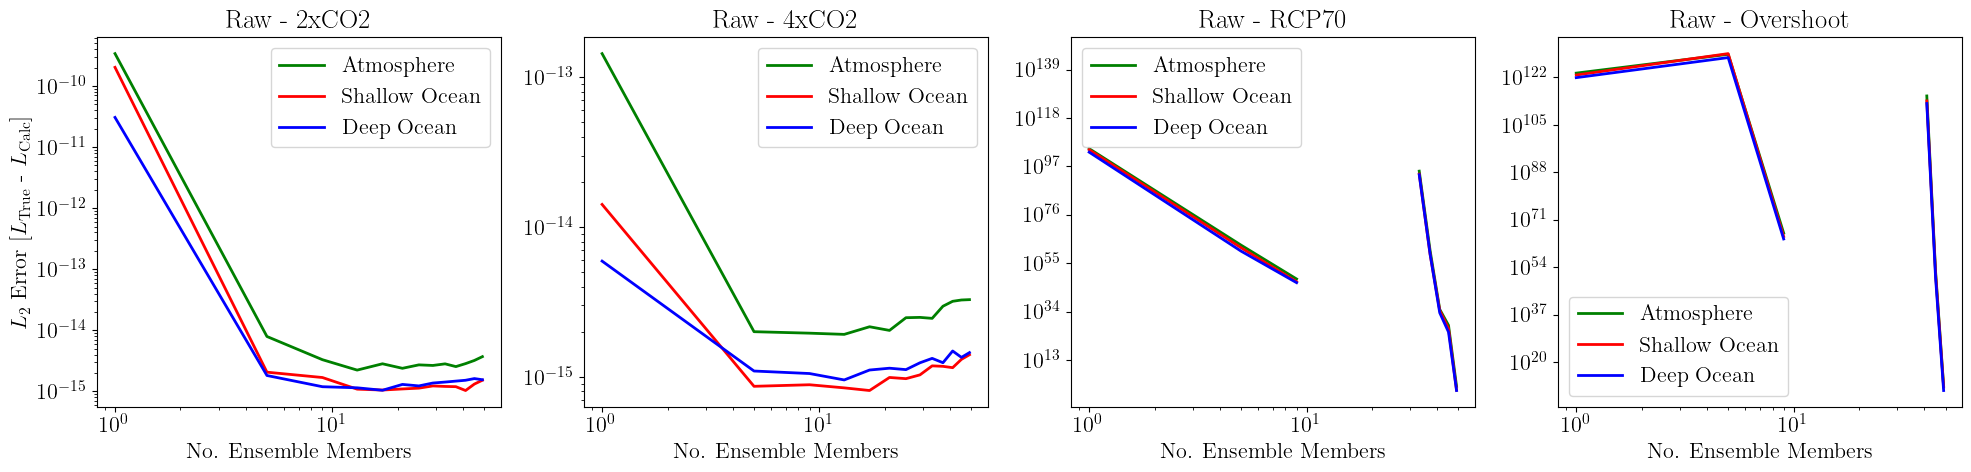

In [10]:
# Instantiate data structures
G_deconv_ensemble = {}
L2_operator_deconv = {}
for exp in experiments:
  G_deconv_ensemble[exp] = {}
  L2_operator_deconv[exp] = {}
  for reg in regions:
    G_deconv_ensemble[exp][reg] = np.zeros((N_ensemble, len(t)))
    L2_operator_deconv[exp][reg] = []

# Iterate over ensemble members
N_samples = 10
N_trials = range(1, N_ensemble, 4)
for n in N_trials:

  # Instantiate temporary data structures
  G_deconv_sample = {}
  for exp in experiments:
    G_deconv_sample[exp] = {}
    for reg in regions:
      G_deconv_sample[exp][reg] = []

  # Repeat random sampling N_trials times
  for _ in range(N_samples):
    sampled_indices = np.random.choice(N_ensemble, size=n, replace=False)

    # Calculate linear operator
    for exp in experiments:
      F_sample_mean = np.mean(F_all_ensemble[exp][sampled_indices, :], axis=0)
      for i, reg in enumerate(regions):
        T_sample_mean = np.mean(T_ensemble[exp][reg][sampled_indices, :], axis=0)
        #a_sample_mean = np.mean(a_ensemble[exp][reg][sampled_indices, :], axis=0)
        #g_sample_mean = np.mean(g_ensemble[exp][reg][sampled_indices, :], axis=0)

        G_deconv_sample[exp][reg].append(response_utils.calc_G_deconv_1D(T_sample_mean, F_sample_mean, dt=1))
        #g_temp, a_temp = response_utils.calc_modes_1D(G_deconv_sample[exp][reg], t)
        #g_deconv_sample[exp][reg].append(g_temp)
        #a_deconv_sample[exp][reg].append(a_temp)

  # Save average response function
  for exp in experiments:
    for reg in regions:
      G_deconv_ensemble[exp][reg] = np.mean(G_deconv_sample[exp][reg], axis=0)
      #L_modal_ensemble[exp][reg] = np.mean(L_modal_sample[exp][reg])

  # Calculate L2 operator error
  L2_operator_sample_deconv = response_utils.calc_L2_operator(G_deconv, G_deconv_ensemble, experiments, regions)
  #L2_operator_sample_modal = response_utils.calc_L2_operator(L_modal, L_modal_ensemble, experiments, regions)

  for exp in experiments:
    for reg in regions:
      L2_operator_deconv[exp][reg].append(L2_operator_sample_deconv[exp][reg])
      #L2_operator_modal_L[exp][reg].append(L2_operator_sample_modal[exp][reg])

# Plot L2 operator error ensemble
response_utils.plot_L2_operator_ensemble(L2_operator_deconv, N_trials, experiments, regions, colors, 'Raw')
#response_utils.plot_L2_operator_ensemble(L2_operator_modal_L, N_trials, experiments, regions, colors, 'Modal')

#### Method 4: Estimation of response function using only leading timescales

##### a) Without noise

Error from Raw estimation.
	L2 Error, 2xCO2: 0.00056
	L2 Error, 4xCO2: 0.0005
	L2 Error, RCP370: 0.00298
	L2 Error, Overshoot: 2e-05
Avg. L2 Error: 0.00101

Error from Modal estimation.
	L2 Error, 2xCO2: 0.00014
	L2 Error, 4xCO2: 0.00016
	L2 Error, RCP370: 0.00294
	L2 Error, Overshoot: 1e-05
Avg. L2 Error: 0.00081



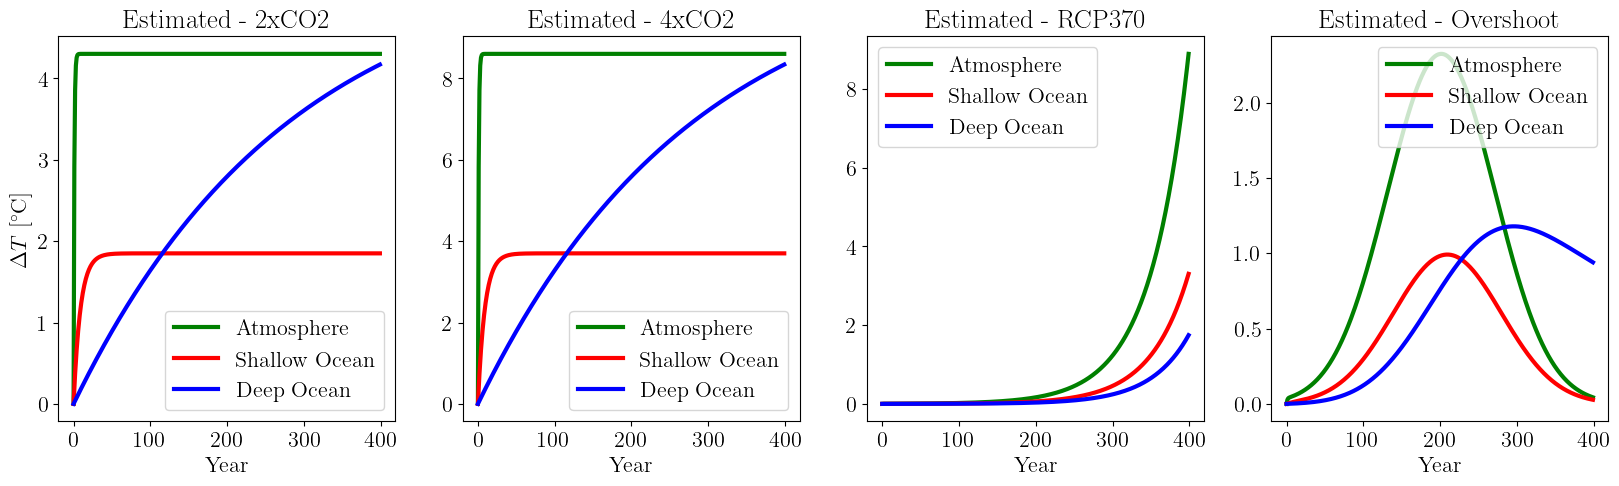

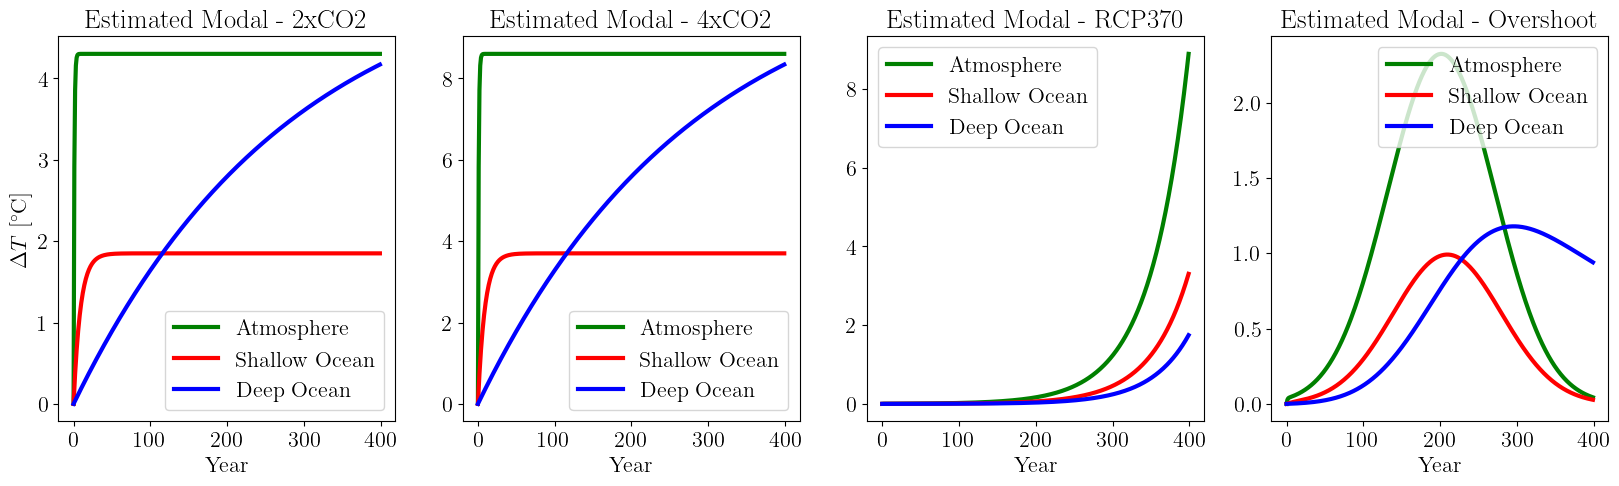

In [26]:
initial_guess = np.array([1, 1])
options = {'disp': False}

res_raw, res_modal = {}, {}
G_fit, a_fit = {}, {}

for exp in experiments:
  res_raw[exp], res_modal[exp] = {}, {}
  G_fit[exp], a_fit[exp] = {}, {}
  for reg in regions:
    res_raw[exp][reg] = minimize(response_utils.opt_h_lam_1D,
                                 initial_guess,
                                 args=(T_analytic[exp][reg], F_all[exp], t, 1),
                                 options=options)
    res_modal[exp][reg] = minimize(response_utils.opt_h_lam_1D,
                                   initial_guess,
                                   args=(a_analytic[exp][reg], F_all[exp], t, 1),
                                   options=options)

    G_fit[exp][reg] = response_utils.apply_response_1D(res_raw[exp][reg].x, t)
    a_fit[exp][reg] = response_utils.apply_response_1D(res_modal[exp][reg].x, t)

T_est_raw_4, T_est_modal_4 = response_utils.estimate_T_1D(T_analytic, F_all,
                                                      experiments, regions,
                                                      t, C, 'G', G_fit, a_fit,
                                                      g_analytic, T0, dt)

response_utils.plot_box_model(T_est_raw_4, t, experiments, regions, colors, soln_type='Estimated')
response_utils.plot_box_model(T_est_modal_4, t, experiments, regions, colors, soln_type='Estimated Modal')

L2_raw_4 = response_utils.calc_L2(T_analytic, T_est_raw_4, experiments, regions, 'Raw')
L2_modal_4 = response_utils.calc_L2(T_analytic, T_est_modal_4, experiments, regions, 'Modal')

##### b) With noise

/Users/chriswomack/Documents/PhD/Project 1/response_utils.py:374: RuntimeWarning: overflow encountered in exp
  G_opt = h*np.exp(-lam*t)
/Users/chriswomack/anaconda3/envs/research/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/chriswomack/anaconda3/envs/research/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/chriswomack/anaconda3/envs/research/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/chriswomack/Documents/PhD/Project 1/response_utils.py:374: RuntimeWarning: overflow encountered in exp
  G_opt = h*np.exp(-lam*t)
/Users/chriswomack/Documents/PhD/Project 1/response_utils.py:374: RuntimeWarning: overflow encountered in exp
  G_opt = h*np.exp(-lam*t)
/Users/chriswomack/Documents/PhD/Project 1/response_utils.

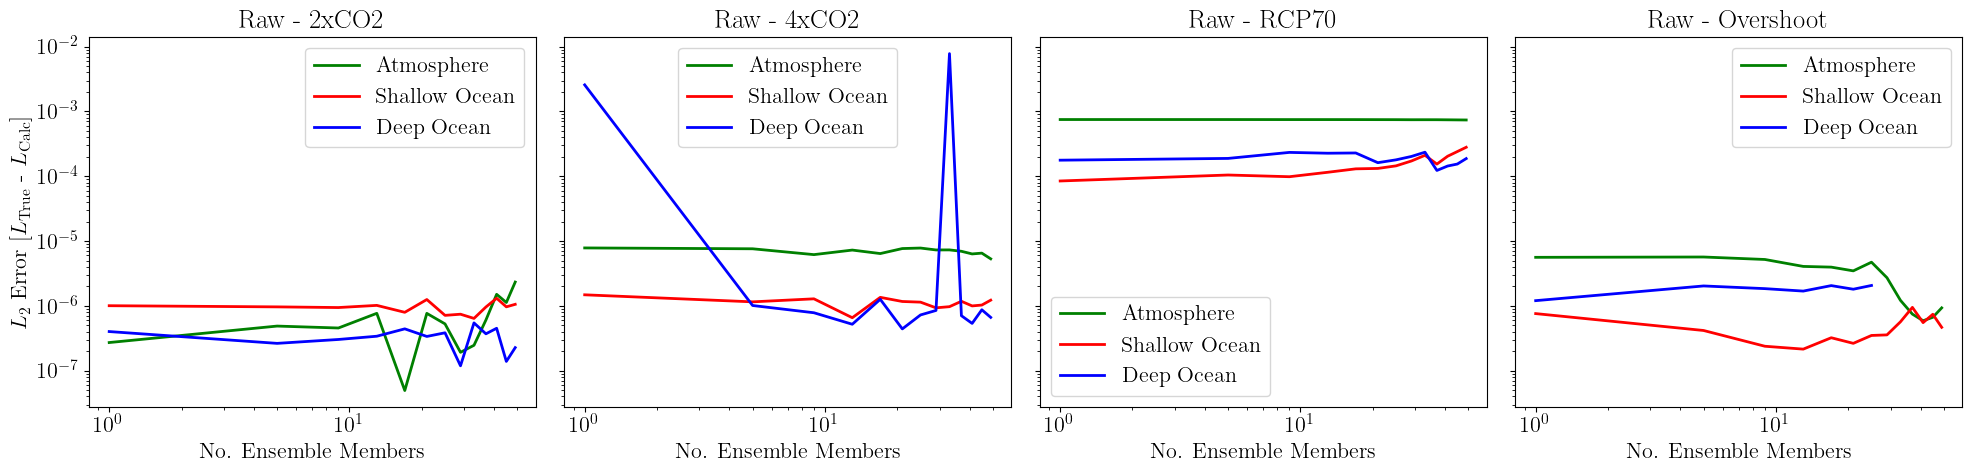

In [12]:
# Instantiate data structures
G_fit_ensemble = {}
L2_operator_fit = {}
for exp in experiments:
  G_fit_ensemble[exp] = {}
  L2_operator_fit[exp] = {}
  for reg in regions:
    G_fit_ensemble[exp][reg] = np.zeros((N_ensemble, len(t)))
    L2_operator_fit[exp][reg] = []

# Iterate over ensemble members
N_samples = 10
N_trials = range(1, N_ensemble, 4)
for n in N_trials:

  # Instantiate temporary data structures
  G_fit_sample = {}
  for exp in experiments:
    G_fit_sample[exp] = {}
    for reg in regions:
      G_fit_sample[exp][reg] = []

  # Repeat random sampling N_trials times
  for _ in range(N_samples):
    sampled_indices = np.random.choice(N_ensemble, size=n, replace=False)

    # Calculate linear operator
    for exp in experiments:
      F_sample_mean = np.mean(F_all_ensemble[exp][sampled_indices, :], axis=0)
      for i, reg in enumerate(regions):
        T_sample_mean = np.mean(T_ensemble[exp][reg][sampled_indices, :], axis=0)

        res_raw = minimize(response_utils.opt_h_lam_1D,
                                    initial_guess,
                                    args=(T_sample_mean, F_sample_mean, t, 1),
                                    options=options)

        G_fit_sample[exp][reg].append(response_utils.apply_response_1D(res_raw.x, t))

  # Save average response function
  for exp in experiments:
    for reg in regions:
      G_fit_ensemble[exp][reg] = np.mean(G_fit_sample[exp][reg], axis=0)

  # Calculate L2 operator error
  L2_operator_sample_fit = response_utils.calc_L2_operator(G_fit, G_fit_ensemble, experiments, regions)

  for exp in experiments:
    for reg in regions:
      L2_operator_fit[exp][reg].append(L2_operator_sample_fit[exp][reg])

# Plot L2 operator error ensemble
response_utils.plot_L2_operator_ensemble(L2_operator_fit, N_trials, experiments, regions, colors, 'Raw')
